In [1]:
# Import modules 

from IPython.core.debugger import set_trace
import gc

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.distributions import Categorical, Bernoulli


import numpy as np
import pandas as pd
from ast import literal_eval
import time

import import_ipynb
from config import *
from environment import *


%load_ext autoreload
%autoreload 2

importing Jupyter notebook from config.ipynb
importing Jupyter notebook from environment.ipynb
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
SEED = 47
torch.manual_seed(SEED)
np.random.seed(SEED) 

In [3]:
config = Config()
config.machine_profile = "small_default"
config.job_profile = "small_default"
config.reconfigure()

file_learn = "datasets/learning_dataset_env_small_default.data"
file_test = "datasets/testing_dataset_env_small_default_tout1000.data"

In [4]:
#################################################################################################

In [5]:
#-----------------------------------------------------------------------------
# Read datasets
#-----------------------------------------------------------------------------
        
learning_machines = []
learning_duration = []

testing_machines = []
testing_duration = []
testing_solver = []


# Learning dataset
num_lines = len(open(file_learn).readlines())
    
with open(file_learn, "r") as file:
    
    for _ in range(num_lines // (config.num_jobs+1)):
        
        # Read an instance from the learning dataset file
        
        # First, read the number as jobs and machines on the instance
        NB_JOBS, NB_MACHINES = [int(v) for v in file.readline().split()]
        
        # For all the operations in the job read the machine assigned to the operation and duration time 
        JOBS = [[int(v) for v in file.readline().split()] for i in range(NB_JOBS)]

        # Build list of machines for each operation. MACHINES[j][s] = id of the machine for the operation s of the job j
        learning_machines.append([[JOBS[j][2 * s] for s in range(NB_MACHINES)] for j in range(NB_JOBS)])

        # Build list of durations for each operation. DURATION[j][s] = duration of the operation s of the job j
        learning_duration.append([[JOBS[j][2 * s + 1] for s in range(NB_MACHINES)] for j in range(NB_JOBS)])


learning_machines = np.array(learning_machines)
learning_duration = np.array(learning_duration)

# Testing dataset
num_lines = len(open(file_test).readlines())
    
with open(file_test, "r") as file:
    
    for _ in range(num_lines // (config.num_jobs+2)):
        
        # Read an instance from the testing dataset file
        
        # First, read the number as jobs and machines on the instance
        NB_JOBS, NB_MACHINES = [int(v) for v in file.readline().split()]
        
        # For all the operations in the job read the machine assigned to the operation and duration time 
        JOBS = [[int(v) for v in file.readline().split()] for i in range(NB_JOBS)]
        
        # Read the solver makespan previously computed
        testing_solver.append(int(float(file.readline().split()[1])))
        
        # Build list of machines. MACHINES[j][s] = id of the machine for the operation s of the job j
        testing_machines.append([[JOBS[j][2 * s] for s in range(NB_MACHINES)] for j in range(NB_JOBS)])

        # Build list of durations. DURATION[j][s] = duration of the operation s of the job j
        testing_duration.append([[JOBS[j][2 * s + 1] for s in range(NB_MACHINES)] for j in range(NB_JOBS)])
        

testing_machines = np.array(testing_machines)
testing_duration = np.array(testing_duration)
testing_solver = np.array(testing_solver)


In [6]:
device="cuda:0"

In [7]:
def computeTestingError(inference=False):

    BSS=20 # Batch size
    LSS=40 # Number of times the same instance is repeated into the agent to create the output distribution used to create the self competing baseline


    # Placements of the best solution (just to plot the Gantt diagrams)
    placementsBest = []
    
    diffBest = []
    averError = []
    averDiff = []
    
    # Number of minibatches
    IterPerEpoch = len(testing_machines)//BSS
    
    with torch.no_grad():
        
        for it in range(IterPerEpoch):
            
            # Select the intances and replicate the instances BSS times
            machines = testing_machines[it*BSS:(it+1)*BSS]
            machines = np.concatenate([machines for _ in range(LSS)])
            duration = testing_duration[it*BSS:(it+1)*BSS]
            duration = np.concatenate([duration for _ in range(LSS)])

            
            # Evaluate into the model
            start_time = time.time()
            rewards, logProbs, probs, actions_bare, actions, jobTime, placements = actor.forward(machines, duration, inference)
            elapsed_time = time.time() - start_time

            # Get the solver solution
            cv = testing_solver[it*BSS:(it+1)*BSS]
            cv = np.concatenate([cv for j in range(LSS)])
            
            # Compute the difference between the model and the solver
            diff = rewards.cpu().data.numpy() - cv
            
            # Extract the solution with the lowest gap to the solver from the BSS instances
            diffBest.extend(np.min(diff.reshape([LSS,BSS]),0))
            
            if inference:
                
                # Compute the placements for the best solution
                idxsBest = np.argmin(diff.reshape([LSS,BSS]),0)
                placements = placements.cpu().data.numpy()
                placements = placements.reshape([LSS,BSS,config.num_machines,config.num_tasksperjob,2])

                for i in range(BSS):
                    placementsBest.append(placements[idxsBest[i],i,:,:,:])


            averDiff.append(np.mean(diff)) # Mean difference to the solver in the BSS instances
            averError.append(np.sum(diff > .01)/BSS) # No of samples with error per BSS batch
            
 
    return np.mean(averError), np.mean(averDiff), diffBest, placementsBest

In [8]:
class Actor(nn.Module):
    
    def __init__(self, config):
        
        super(Actor, self).__init__() 
        
        self.config = config
        
        #-----------------------------------------------------------------------------
        # Nerual Network
        #-----------------------------------------------------------------------------
        
        # Embedding layers
        self.jobsEmbedding = nn.Linear(2, config.embedding_size,  bias=False)  
        self.stateEmbedding = nn.Linear(config.num_jobs*2, config.embedding_size,  bias=False)  
        
        # Recurrent encoder used to embed the operations in each job
        self.encoder = nn.LSTM(input_size= config.embedding_size, hidden_size=config.embedding_size, num_layers= 1, batch_first=True)
        
        
        # Fully connected layres to output the action distribution
        self.activation = F.relu
        self.fc1 = nn.Linear(config.embedding_size*(config.num_jobs+1), 128, bias=True)
        self.fc2 = nn.Linear(512, 128, bias=True)  # Layer used in: medium, large and xlarge
        self.fc3 = nn.Linear(128, config.num_jobs*2, bias=True)  
        
        #nn.init.xavier_normal(self.fc1.weight)
       
    
    def forward(self, machines, duration, inference=False):
        
        #-----------------------------------------------------------------------------
        # Generate the input tensors
        #-----------------------------------------------------------------------------

        BS = machines.shape[0]
        
        machines = np.append(machines, np.zeros((BS, self.config.num_jobs, 1)), axis=2)
        duration = np.append(duration, np.zeros((BS, self.config.num_jobs, 1)), axis=2)
        

        assert self.config.num_jobs == machines.shape[1]
        assert self.config.num_tasksperjob +1 == machines.shape[2] 

        
        self.machines = torch.Tensor(machines).to(device)
        self.duration = torch.Tensor(duration).to(device)
        
        
        # Create the tensor that defines the instance of the problem
        self.jobs = torch.stack((self.machines, self.duration), dim = 3) # [batch, jobs, machines, 2]
        
        
        #-----------------------------------------------------------------------------
        # Jobs embedding using the same LSTM
        #-----------------------------------------------------------------------------
        
        # Embedding
        embeddedJobs = self.jobsEmbedding(self.jobs) # [batch, jobs, machines, embeddings]
        
        # Serializing to input into the RNN
        serializedJobs = torch.unbind(embeddedJobs, dim=1) # list of [batch, machines, embeddings] for each job
     
        outputJobs = [[] for _ in range(self.config.num_jobs)]   
        
        # Compute the recurrent encoding
        for i in range(self.config.num_jobs):
        
            h = torch.zeros([1, BS, config.embedding_size], device=device)
            c = torch.zeros([1, BS, config.embedding_size], device=device)

            outputs = []
            outputsh = []
            outputsc = []

            for j in range(self.config.num_tasksperjob-1, -1, -1):
                
                output, (h , c ) = self.encoder(serializedJobs[i][:,j:j+1,:], (h , c ))
                outputs.insert(0,output.squeeze(1))
                outputsh.insert(0,h.squeeze(0))
                outputsc.insert(0,c.squeeze(0))
                
            outputJobs[i] =  outputsh
            
        # Add a last task embedded as zeros for every job
        emptyEmbeddings = torch.zeros([BS, self.config.embedding_size], device=device)
        [job.append(emptyEmbeddings) for job in outputJobs]                                           # [jobs, tasks+1] -> [batch, embedding]
        
        # Stack the oputput
        outputJobs = torch.stack([torch.stack(job, dim=1) for job in outputJobs], dim=1).to(device)   # [batch, jobs, tasks+1, embedding]
        
        #-----------------------------------------------------------------------------
        # Iteration with the environment
        #-----------------------------------------------------------------------------
        
        actions = []
        actions_bare = []
        probs = []
        logProbs = []
        
        # Index that point to the operations to be scheduled at that time-step
        indexes = torch.zeros([BS, self.config.num_jobs], device=device, dtype=torch.long)
        
        mask = torch.ones([BS, self.config.num_jobs], device=device, dtype=torch.long)
        maxTasks = torch.ones([BS, self.config.num_jobs], device=device, dtype=torch.long) * self.config.num_tasksperjob
        
        # State 0: remaining time for the machine where i should place the task to be free
        state0 = torch.zeros([BS, self.config.num_jobs], device=device)
        state0T = torch.t(state0)
        
        # State 1: remaining time for the previous task to end
        state1 = torch.zeros([BS, self.config.num_jobs], device=device)
        
        # Remaining time in each machine
        machineTime = torch.zeros([BS, self.config.num_machines], device=device, dtype=torch.float)  # [batch. machines]
        
        # Remaining time of the prevous task to end = state 1
        previousTaskTime = torch.zeros([BS, self.config.num_jobs], device=device, dtype=torch.long)  # [batch, jobs]
        
        # Makespan is the largest of the job times
        jobTime = torch.zeros([BS, self.config.num_jobs], device=device, dtype=torch.long)# [batch, jobs]
        
        # Action correction variables
        tmp = torch.zeros([BS, self.config.num_machines], device=device)
        tmp2 = torch.zeros([BS, self.config.num_jobs],  device=device, dtype=torch.long)
        tmp2T = torch.t(tmp2)
        
        # Placements
        placements0 = torch.zeros([BS, self.config.num_machines, self.config.num_tasksperjob+1], device=device, dtype=torch.float)
        placements1 = torch.zeros([BS, self.config.num_machines, self.config.num_tasksperjob+1], device=device, dtype=torch.float)
        placements = torch.stack([placements0[:,:,:-1], placements1[:,:,:-1]], dim=3).int()  
        
        indx_placements = torch.zeros([BS, self.config.num_machines], device=device, dtype=torch.long)
        
        
        #-----------------------------------------------------------------------------
        # Allocation loop, while every task has been placed, binary decissions 0/1
        #-----------------------------------------------------------------------------

        lastOutputJobs = outputJobs[:,:,-1,:]
        lastOutputJobs = torch.flatten(lastOutputJobs, start_dim=1)
        
        while ~torch.all(maxTasks - indexes == 0):   
            
            indexes_ = torch.unsqueeze(indexes, -1)
            indexes_ = torch.unsqueeze(indexes_, -1)
            indexes_ = indexes_.expand(-1,-1,-1,self.config.embedding_size)
            tasks2place = torch.gather(outputJobs, 2, indexes_).squeeze(2)    # [batch, jobs, embeddings]
            tasks2place = torch.flatten(tasks2place, start_dim=1)
            
            
            indexes_ = torch.unsqueeze(indexes, -1)
            machinesGather = torch.gather(self.machines, 2, indexes_).squeeze(2).long()       # [batch, job]
            durationGather = torch.gather(self.duration, 2, indexes_).squeeze(2).long()       # [batch, job]
            
            state = torch.stack([state0/10.0, state1/10.0], dim=2)  # Normalize the state
            state = torch.flatten(state, start_dim=1)
            
            # State Embedding
            embeddedState = self.stateEmbedding(state) # [batch, jobs, embeddings]
    
            # Concatenation to create the input to the model
            jobsAndStates = torch.cat([tasks2place, embeddedState], 1)    

            
            # Decoder DNN
            out = self.fc1(jobsAndStates)
            out = self.fc3(out)
            out = out.view(BS,-1, 2)
            
            # Output distribution
            m = Categorical(logits=out)
          
            
            prob = m.probs
            entropy = m.entropy()
            action_bare = m.sample().long()
            log_prob = m.log_prob(action_bare)
            

            # Mask avoiding to place in machines that are working or place before the previous task ends.
            action = action_bare * mask
            
            ##################################################################
            # Action correction: if two tasks that belong to the same machine are 
            # intended to be placed, only the first one is scheduled.
            
            tmp[:,:] = 0
            tmp2[:,:] = 0
            
            
            for actionT_, machinesGatherT_ in zip(torch.t(action), torch.t(machinesGather)):
                tmp.index_put_([torch.tensor(range(BS), device=device), machinesGatherT_], actionT_.float(),  accumulate=True)
            
            for i, (machinesGatherT_, actionT_) in enumerate(zip(torch.t(machinesGather),torch.t(action))):
                
                tmp[range(BS), machinesGatherT_] = tmp[range(BS), machinesGatherT_] - actionT_
                
                w = (tmp[range(BS), machinesGatherT_] == 0) & (actionT_[range(BS)] == 1)
                tmp2T[i] = w.float()

            
            action = tmp2
            
            ####################################################################
            # Update placements
            if inference:
                for action_, machinesGather_, placements0_, placements1_, indx_placements_, indexes_ in zip(action, machinesGather, placements0, placements1, indx_placements, indexes):

                    placements0_.index_put_([machinesGather_, indx_placements_[machinesGather_]], torch.tensor(range(self.config.num_machines),  device=device, dtype=torch.float) * action_.float(),  accumulate=True)
                    placements1_.index_put_([machinesGather_, indx_placements_[machinesGather_]], indexes_ * action_.float(),  accumulate=True)

                    indx_placements_.put_(machinesGather_, action_,  accumulate=True)

                placements = torch.stack([placements0[:,:,:-1], placements1[:,:,:-1]], dim=3).int()   
            
            
            ####################################################################
            # Update state
            
            durationGather = durationGather * action.long()      # [batch, job]
            
                        
            for machinesGatherT_, durationGatherT_  in zip(torch.t(machinesGather), torch.t(durationGather)):
                machineTime.index_put_([torch.arange(BS, device=device), machinesGatherT_], durationGatherT_.float(),  accumulate=True)
            

            previousTaskTime = previousTaskTime + durationGather
            
            # Update the index of the next tasks to be placed
            indexes = indexes + action
            
            
            # Update total time       
            jobTime = jobTime + (~(indexes == self.config.num_tasksperjob)).int()
            
            # Time pases one unit
            previousTaskTime = torch.max(previousTaskTime-1 , torch.zeros([BS, self.config.num_jobs], device=device, dtype=torch.long))
            machineTime = torch.max(machineTime-1 , torch.zeros([BS, self.config.num_machines], device=device))
            
            
            # Update state
            indexes_ = torch.unsqueeze(indexes, -1)
            
            machinesGather = torch.gather(self.machines, 2, indexes_).squeeze(2).long()               # [batch, job]
   
            for i, (machinesGatherT_, machineTimeT_)  in enumerate(zip(torch.t(machinesGather), torch.t(machineTime))):
                state0T[i] = machineTime[range(BS), machinesGatherT_]


            state1 = previousTaskTime.float()
            
            # Mask to avoid place in machines that are working or place before the previous task ends.
            mask = (~(state0.bool() | state1.bool()) & (indexes != self.config.num_tasksperjob)).int()
            

            # Append
            actions.append(action)
            actions_bare.append(action_bare)
            probs.append(prob)
            logProbs.append(log_prob)
            

        # Stack
        logProbs = torch.stack(logProbs)
        actions = torch.stack(actions)
        actions_bare = torch.stack(actions_bare)
        probs = torch.stack(probs)

        
        # Mask probs after last decision
        mask2 = torch.zeros(actions.shape[0], BS, self.config.num_jobs, device=device)
        for i in range(BS):
            for j in range(self.config.num_jobs):
                
                mask2[0:jobTime[i,j]+1,i,j] = 1
        
        logProbs = logProbs * mask2
        
        
        # Adjust jobTime adding last task
        jobTime = jobTime + self.duration[:,:,-2].long()
        
        # Compute the makespan and assign it as the reward
        rewards = torch.max(jobTime, dim=1).values
        

        return rewards, logProbs, probs, actions_bare, actions, jobTime, placements
        

In [9]:
# Create an instance of the actor
actor = Actor(config).to(device)

In [10]:
# Testing the actor...
rewards, logProbs, probs, actions_bare, actions, jobTime, placements = actor.forward(testing_machines, testing_duration, inference=True)
max_reward = 100.0

In [11]:
#################################################################################################

In [12]:
# Learning process

lr=0.0005 # Learning rate
BS=20 # Batch size
LS=40 # Number of times the same instance is repeated into the agent to create the output distribution used to create the self competing baseline

# No iterations per epoch
IterPerEpoch = len(learning_machines)//BS

# Instantiate the actor and configure the optimizer
actor = Actor(config).to(device)  
actor_optim = optim.Adam(actor.parameters(), lr=lr)

# Index of the learning dataset
allSamples=[i for i in range(len(learning_machines))]

# Decrearning learning rate by gamma every epoch 
#gamma = np.float_power(1e-1,1/200.0)
#scheduler = torch.optim.lr_scheduler.StepLR(actor_optim, len(allSamples)//BS, gamma=gamma, last_epoch=-1)

TESTING_AvgError=[]
TESTING_AvgDiff=[]

------------ 0 : 2.15s
loss:  tensor(13195.0293, device='cuda:0')
RVV:  tensor(1.1324, device='cuda:0')
logProp:  tensor(-578.9905, device='cuda:0')
DiffBest:  19.25


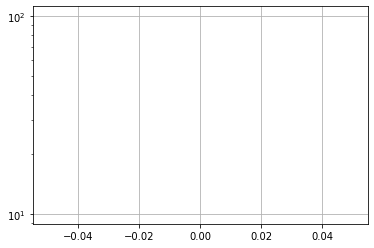

------------ 10 : 2.17s
loss:  tensor(10843.4307, device='cuda:0')
RVV:  tensor(1.1107, device='cuda:0')
logProp:  tensor(-490.1207, device='cuda:0')
DiffBest:  15.925


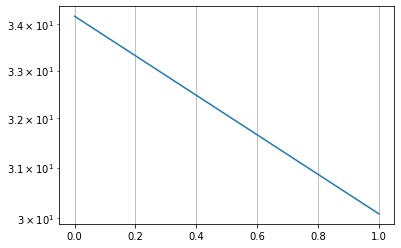

------------ 20 : 2.08s
loss:  tensor(9119.6982, device='cuda:0')
RVV:  tensor(1.0788, device='cuda:0')
logProp:  tensor(-382.6862, device='cuda:0')
DiffBest:  14.85


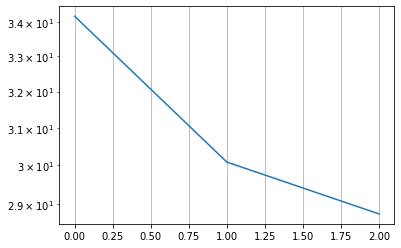

------------ 30 : 2.11s
loss:  tensor(3923.9832, device='cuda:0')
RVV:  tensor(1.0889, device='cuda:0')
logProp:  tensor(-302.9136, device='cuda:0')
DiffBest:  14.25


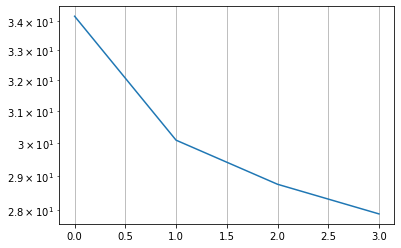

------------ 40 : 2.04s
loss:  tensor(5178.1777, device='cuda:0')
RVV:  tensor(1.0574, device='cuda:0')
logProp:  tensor(-226.2928, device='cuda:0')
DiffBest:  14.2


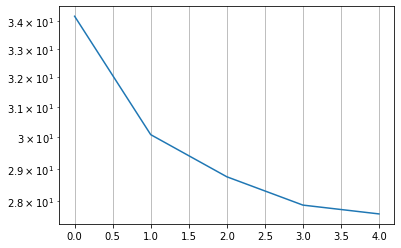

------------ 50 : 2.01s
loss:  tensor(3379.3398, device='cuda:0')
RVV:  tensor(1.0579, device='cuda:0')
logProp:  tensor(-196.4364, device='cuda:0')
DiffBest:  14.65


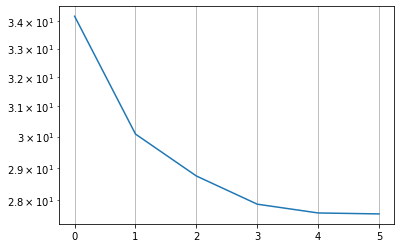

KeyboardInterrupt: 

In [13]:
# Run for 50 epochs
for _ in range(50):

    # Shuffle the data in each epoch on the learning dataset
    np.random.shuffle(allSamples)
        
    for it in range(IterPerEpoch):
        
        start = time.time()
        
        actor_optim.zero_grad()

        # Select the indexes used on the minibatch
        idxs = allSamples[it*BS:(it+1)*BS]

        # Extract the instance definition for the minibatch
        machines = learning_machines[idxs]
        machines = np.concatenate([machines for _ in range(LS)])
        duration = learning_duration[idxs]
        duration = np.concatenate([duration for _ in range(LS)])

        # Run an episode on the problem and return the history
        rewards, logProbs, probs, actions_bare, actions, jobTime, _  = actor.forward(machines, duration)

        # Normalize the rewards
        rewards = rewards / max_reward

        # Aggregate the rewards to reinforce the agent 
        y = torch.sum(logProbs,0)
        yyy = torch.sum(y,1)

        # Reshape the return so that for each instance (ROW), the (COLUMNS) represent the different outputs the stochastic policy produces
        RVV = rewards.reshape([LS, BS])
        
        # Select the baseline as the quantile 'q' of the oputput distribution for each instance
        q = np.quantile(RVV.cpu().data.numpy(), 0.1, axis=0)
        
        # Compute the advantage as the difference between reward and baseline
        RVV = RVV-torch.tensor(q).float().to(device)
        
        # (Optional) Extra computations we were trying to heightened the top advantages the policy produces
        ID = (torch.mean(RVV,0) > 0.001)
        A = torch.sum(RVV,0)  
        B = 1./(0.01+torch.sum(RVV==0,0).float())
        RVV+=((RVV<=0)*ID).float()*(-A*B.float())
        
        # Serialize the advantage
        RVV = RVV.view(-1)

        # Compute the loss as: advantage * log(pi)
        loss =  torch.mean(RVV * yyy)
        
        # Compute backpropagation
        loss.backward(retain_graph=True)

        # Clip the gradient to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(actor.parameters(), 0.1)
        
        # Perform a optimization step
        actor_optim.step()

        end = time.time()

        # Print some learning information
        if it%10 == 0:
            print("------------", it, ": {0:.2f}s".format(end - start))
            print("loss: ", loss.data)  # loss
            print("RVV: ", torch.mean(rewards.float()).data) # advantage
            print("logProp: ", torch.mean(yyy).data) # policy
            
        
        # Plot the tesing error computed during the learning process
        if it%10 == 0:
            
            # Evaluate the testing dataset during the learning process
            AvgError, AvgDiff, DiffBest, _ = computeTestingError()
            TESTING_AvgError.append(AvgError) # No of samples with error per BSS batch
            TESTING_AvgDiff.append(AvgDiff) # Mean difference to the solver in the BSS instances
            
            # Plot the mean difference between the best solution for the BS trials and the solver solution
            print("DiffBest: ", np.mean(DiffBest))
            plt.semilogy(TESTING_AvgDiff)
            plt.grid(True)
            plt.show()
